# Chapter 5: Causal Model Discovery from Data

## Key Points Learned in this chapter

### 1. Causal Discovery vs. Correlation  
Causal discovery identifies cause-effect relationships, while correlation only measures statistical dependencies.

### 2. PC Algorithm and Independence Testing  
The PC algorithm discovers causal structures by testing conditional independence between variables.

### 3. Score-Based Methods and GES  
GES evaluates causal graphs by optimizing a score based on likelihood and graph complexity.

### 4. Functional Causal Models: LiNGAM and ANM  
LiNGAM and ANM assume specific functional forms, like linear and additive noise relationships.

### 5. Evaluating Causal Models  
Precision, recall, F1 score, and SHD assess how well discovered graphs match true relationships.

  
---

### 1. Introduction to Causal Model Discovery

Causal model discovery identifies cause-effect relationships between variables using data. It is particularly useful in observational data where controlled experiments are impractical or impossible. Unlike correlation, which only measures statistical dependencies between variables, causal discovery seeks to uncover which variables influence others directly, enabling more accurate predictions and interventions.

#### Healthcare Example: Causal Links Between Lifestyle and Health Outcomes
In healthcare, causal discovery is used to understand how lifestyle factors (e.g., smoking, exercise) impact health outcomes such as heart disease and diabetes. Causal models help in identifying which factors to target for preventive measures.

**Visualization: Correlation Matrix**


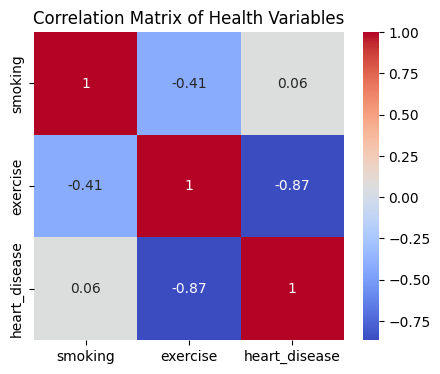

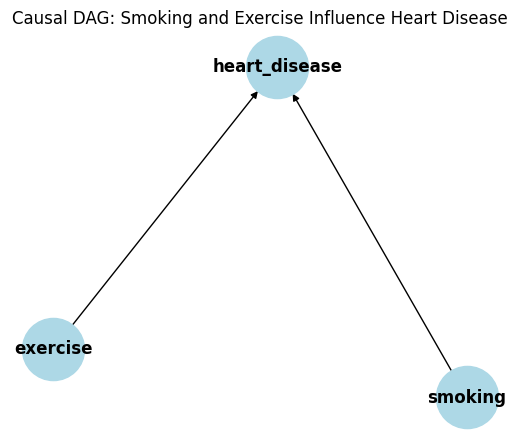

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Hypothetical health dataset (replace with real data)
df = pd.DataFrame({
    'smoking': [5, 20, 15, 7, 10],
    'exercise': [3, 2, 5, 6, 4],
    'heart_disease': [1, 1, 0, 0, 1]
})

# Visualize correlations between variables
plt.figure(figsize=(5, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Health Variables')
plt.show()

# Create a Directed Acyclic Graph (DAG) representing causal assumptions
G = nx.DiGraph()

# Add edges according to causal assumptions
G.add_edge('smoking', 'heart_disease')
G.add_edge('exercise', 'heart_disease')

# Visualize the DAG
plt.figure(figsize=(5, 4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', arrows=True)
plt.title("Causal DAG: Smoking and Exercise Influence Heart Disease")
plt.show()



In this example, we plot a correlation matrix to observe the relationships between three variables: smoking, exercise, and heart disease. The correlation matrix shows how strongly each pair of variables is related to each other, but it does not imply causality. For example, smoking might have a strong correlation with heart disease, but to truly understand the causal relationship, we need more advanced methods like those in this chapter.


---

## 2. Methods of Causal Discovery

Causal discovery methods aim to infer causal relationships from observational data. These methods can be broadly categorized into three main groups, each with its own strengths and assumptions. We'll explore these categories and delve deeper into the PC Algorithm as an example of independence-based methods.


### 2.1 Overview of Causal Discovery Methods

1. **Independence-based methods**
   - Rely on conditional independence tests
   - Examples: PC Algorithm, FCI (Fast Causal Inference)
   - Strengths: Can handle high-dimensional data, robust to some forms of model misspecification
   - Limitations: Sensitive to errors in independence tests, assume causal sufficiency (no unmeasured confounders)

2. **Score-based methods**
   - Use a scoring function to evaluate and compare different causal structures
   - Examples: Greedy Equivalence Search (GES), Bayesian network learning algorithms
   - Strengths: Can incorporate prior knowledge, often more robust to small sample sizes
   - Limitations: Can be computationally intensive for large networks

3. **Functional causal discovery methods**
   - Exploit additional assumptions about the functional form of causal relationships
   - Examples: LiNGAM (Linear Non-Gaussian Acyclic Model), ANM (Additive Noise Model)
   - Strengths: Can identify causal direction in certain cases where other methods fail
   - Limitations: Rely on specific assumptions about functional forms and noise distributions

---

### 2.2 Independence-Based Methods: The PC Algorithm

The PC Algorithm, named after its inventors Peter Spirtes and Clark Glymour, is a fundamental algorithm in the field of causal discovery. It belongs to the class of constraint-based methods, which rely on conditional independence tests to infer causal structures ([refrence](https://applied-informatics-j.springeropen.com/articles/10.1186/s40535-016-0018-x)).

#### Key Concepts

1. **Causal Markov Assumption**: Given a causal DAG (Directed Acyclic Graph), each variable is independent of its non-descendants given its parents.

2. **Faithfulness Assumption**: All conditional independence relationships in the data are implied by the causal Markov assumption applied to the true causal graph.

#### Mathematical Formulation

The PC Algorithm aims to identify conditional independence relationships of the form:

$$
X_i \perp X_j \mid \mathbf{S}
$$

where $X_i$ and $X_j$ are variables in the dataset, and $\mathbf{S}$ is a subset of the other variables. The symbol $\perp$ denotes statistical independence.

#### Algorithm Steps

1. **Start with a complete undirected graph**
   - Initially assume all variables are connected

2. **Edge removal phase**
   - For each pair of variables $(X_i, X_j)$:
     - Test for marginal independence: $X_i \perp X_j$
     - If independent, remove the edge between $X_i$ and $X_j$
   - For increasing conditioning set sizes:
     - Test conditional independence: $X_i \perp X_j \mid \mathbf{S}$
     - If a separating set $\mathbf{S}$ is found, remove the edge

3. **Edge orientation phase**
   - Orient v-structures: $X_i \rightarrow X_k \leftarrow X_j$ if $X_i$ and $X_j$ are not adjacent and $X_k$ is not in the separating set of $X_i$ and $X_j$
   - Apply orientation rules to derive additional edge directions

#### Mathematical Details of Independence Testing

For Gaussian variables, conditional independence can be tested using partial correlations:

$$
\rho_{X_i,X_j|\mathbf{S}} = \frac{\rho_{X_i,X_j} - \rho_{X_i,\mathbf{S}}\rho_{X_j,\mathbf{S}}}{\sqrt{(1-\rho_{X_i,\mathbf{S}}^2)(1-\rho_{X_j,\mathbf{S}}^2)}}
$$

Where $\rho_{X_i,X_j|\mathbf{S}}$ is the partial correlation between $X_i$ and $X_j$ given $\mathbf{S}$.

For discrete variables, conditional independence can be tested using the G-test or chi-squared test.


#### Example: Disease-Symptom Causal Discovery
We use the PC algorithm to learn the causal relationships between diseases (e.g., tuberculosis, bronchitis) and symptoms (e.g., dyspnea).


  0%|          | 0/5 [00:00<?, ?it/s]

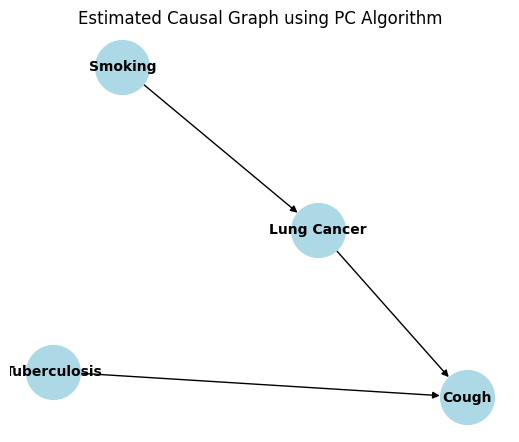

In [167]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

# Generate synthetic data
np.random.seed(42)
n_samples = 1000

# Simulate causal relationships
tuberculosis = np.random.binomial(1, 0.05, n_samples)
smoking = np.random.binomial(1, 0.2, n_samples)
lung_cancer = np.random.binomial(1, 0.01 + 0.1*tuberculosis + 0.3*smoking, n_samples)
cough = np.random.binomial(1, 0.1 + 0.6*tuberculosis + 0.3*lung_cancer, n_samples)

data = pd.DataFrame({
    'Tuberculosis': tuberculosis,
    'Smoking': smoking,
    'Lung Cancer': lung_cancer,
    'Cough': cough
})

# Apply PC algorithm
pc = PC(data)
estimated_model = pc.estimate()

# Visualize the result with a smaller DAG
G = nx.DiGraph()
G.add_edges_from(estimated_model.edges())

# Adjust the figure size to make the DAG smaller
pos = nx.spring_layout(G)
plt.figure(figsize=(5, 4))  # Smaller figure size
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): '' for (u, v) in G.edges()})
plt.title("Estimated Causal Graph using PC Algorithm")
plt.show()


After applying the PC algorithm, a causal graph is generated showing the relationships between diseases (e.g., tuberculosis, bronchitis) and symptoms (e.g., dyspnea). 

---

## 2.2 Score-Based Methods: Greedy Equivalence Search (GES)

Score-based methods in causal discovery aim to find the causal graph that best explains the observed data according to a predefined scoring criterion. Among these methods, Greedy Equivalence Search (GES) stands out as a popular and efficient algorithm ([Reference](https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf)).

### Overview of Greedy Equivalence Search (GES)

Greedy Equivalence Search, introduced by Chickering (2002), is a search-based algorithm that explores the space of possible causal graphs to find the one that maximizes a given score function. GES operates on equivalence classes of Directed Acyclic Graphs (DAGs), known as Completed Partially Directed Acyclic Graphs (CPDAGs).

Key features of GES:
1. Starts with an empty graph and performs a forward phase of edge additions
2. Follows with a backward phase of edge removals
3. Uses a scoring criterion to evaluate graph changes
4. Guarantees to find the optimal graph under certain assumptions

### Mathematical Formulation

GES typically uses the Bayesian Information Criterion (BIC) as its scoring function, though other scores like the Akaike Information Criterion (AIC) or Minimum Description Length (MDL) can also be used ([Reference](https://www.jmlr.org/papers/volume5/chickering04a/chickering04a.pdf)).

#### Bayesian Information Criterion (BIC)

The BIC score for a model $M$ is defined as:

$$
\text{BIC}(M) = \log \mathcal{L}(M \mid D) - \frac{k \log N}{2}
$$

Where:
- $\mathcal{L}(M \mid D)$ is the likelihood of the model given data $D$
- $k$ is the number of free parameters in the model
- $N$ is the number of observations in the dataset

The BIC balances model fit (captured by the likelihood term) with model complexity (penalized by the second term).

#### GES Algorithm Steps

1. **Forward Phase**: 
   Start with an empty graph and iteratively add edges that maximize the increase in the BIC score.
   
   For each potential edge addition $e$:
   $$\Delta \text{BIC}(e) = \text{BIC}(M_{new}) - \text{BIC}(M_{current})$$
   Add the edge $e$ that maximizes $\Delta \text{BIC}(e)$ if it's positive.

2. **Backward Phase**: 
   Starting from the graph obtained in the forward phase, iteratively remove edges that maximize the increase in the BIC score.
   
   For each potential edge removal $e$:
   $$\Delta \text{BIC}(e) = \text{BIC}(M_{new}) - \text{BIC}(M_{current})$$
   Remove the edge $e$ that maximizes $\Delta \text{BIC}(e)$ if it's positive.

3. **Stopping Criterion**: 
   The algorithm stops when no edge addition or removal can increase the BIC score.

### Theoretical Guarantees

Under certain assumptions, including:
- The true causal structure is a DAG
- The data is generated from a multivariate Gaussian distribution
- The sample size is sufficiently large

GES is guaranteed to recover the correct Markov equivalence class of the true causal graph.

### Advantages and Limitations

Advantages:
1. Can handle high-dimensional data efficiently
2. Provides a principled way to balance model fit and complexity
3. Has theoretical guarantees under certain conditions

Limitations:
1. Assumes causal sufficiency (no unmeasured confounders)
2. May struggle with non-linear relationships or non-Gaussian noise
3. Can be sensitive to hyperparameter choices and sample size


#### Example: Economic Factors Causal Discovery
We use GES to identify causal relationships between macroeconomic variables such as inflation, interest rates, and unemployment.


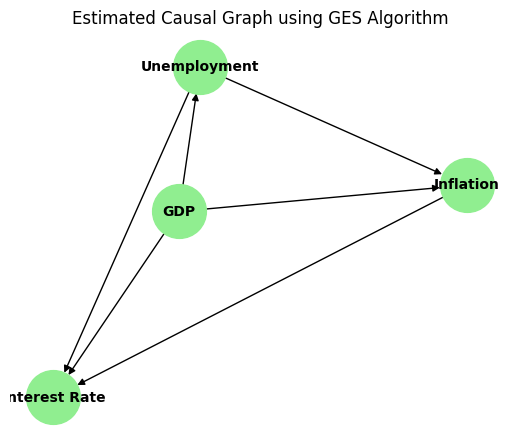

In [170]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import ExhaustiveSearch

# Generate synthetic economic data
np.random.seed(42)
n_samples = 1000

gdp = np.random.normal(0, 1, n_samples)
unemployment = -0.5 * gdp + np.random.normal(0, 0.5, n_samples)
inflation = 0.3 * gdp - 0.2 * unemployment + np.random.normal(0, 0.5, n_samples)
interest_rate = 0.4 * inflation + np.random.normal(0, 0.3, n_samples)

data = pd.DataFrame({
    'GDP': gdp,
    'Unemployment': unemployment,
    'Inflation': inflation,
    'Interest Rate': interest_rate
})

# Apply GES (using ExhaustiveSearch as a substitute)
es = ExhaustiveSearch(data)
best_model = es.estimate()

# Visualize the result with a smaller DAG
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

# Adjust the figure size, node size, and font size for a smaller DAG
pos = nx.spring_layout(G)
plt.figure(figsize=(5, 4))  # Reduced figure size
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): '' for (u, v) in G.edges()})
plt.title("Estimated Causal Graph using GES Algorithm")
plt.show()


The GES algorithm estimates a causal graph between macroeconomic variables such as inflation, interest rates, and unemployment. The estimated graph shows which factors influence others. For instance, the graph might show that inflation causally affects interest rates. The precision of this estimation is influenced by the scoring criterion (such as BIC) used in GES.

---

## 2.3 Functional Causal Discovery: LiNGAM and Additive Noise Models (ANM)

Functional causal discovery methods aim to infer causal relationships from observational data by leveraging specific assumptions about the functional form of causal mechanisms and the properties of noise terms. Two prominent approaches in this category are Linear Non-Gaussian Acyclic Models (LiNGAM) and Additive Noise Models (ANM).

### LiNGAM (Linear Non-Gaussian Acyclic Model)

LiNGAM is a framework for causal discovery that combines linear relationships with non-Gaussian noise assumptions. It was introduced by Shimizu et al. (2006) as a method to overcome limitations of traditional causal discovery algorithms that rely on Gaussian assumptions ([Reference](https://www.jmlr.org/papers/volume7/shimizu06a/shimizu06a.pdf)).

Key features of LiNGAM:
- Assumes linear relationships between variables
- Requires non-Gaussian noise for identifiability
- Can identify the full causal structure, including causal ordering and effect sizes

#### Mathematical Formulation of LiNGAM:

LiNGAM assumes that each variable $X_i$ can be written as a linear function of its parents:

$X_i = \sum_{j \in \text{PA}(i)} a_{ij}X_j + e_i$

Where:
- $X_i$ is the i-th observed variable
- $\text{PA}(i)$ is the set of parent variables of $X_i$ in the causal graph
- $a_{ij}$ are the linear coefficients (causal effects)
- $e_i$ is the noise term, assumed to be non-Gaussian and independent of each other

The non-Gaussian nature of $e_i$ is crucial for the identifiability of the model. LiNGAM leverages Independent Component Analysis (ICA) to estimate the causal structure from the observed data.

### Additive Noise Models (ANM)

Additive Noise Models, introduced by Hoyer et al. (2009), extend the idea of functional causal discovery to nonlinear relationships while maintaining the additive noise assumption ([Reference](https://proceedings.neurips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf)).

Key features of ANM:
- Allows for nonlinear relationships between cause and effect
- Assumes additive and independent noise in the causal direction
- Can identify causal direction in two-variable systems and, under certain conditions, in multivariate systems

#### Mathematical Formulation of ANM:

For a simple bivariate case where $X$ causes $Y$, the ANM assumes:

$Y = f(X) + \epsilon_Y \quad \text{with} \quad \epsilon_Y \perp X$

Where:
- $f(X)$ is a (possibly nonlinear) function of $X$
- $\epsilon_Y$ is the noise term, assumed to be independent of $X$
- $\perp$ denotes statistical independence

The key insight of ANM is that this independence between $X$ and $\epsilon_Y$ typically holds only in the true causal direction. In the reverse direction, the noise term would generally not be independent of the supposed cause.

### Comparison and Applications

Both LiNGAM and ANM offer powerful tools for causal discovery, each with its strengths:

1. **Linearity vs. Nonlinearity**: LiNGAM is restricted to linear relationships but can handle multivariate systems more easily. ANM allows for nonlinear relationships but is most straightforward in bivariate cases.

2. **Noise Assumptions**: LiNGAM requires non-Gaussian noise, while ANM focuses on the independence of noise from the cause.

3. **Identifiability**: LiNGAM can identify the full causal structure in multivariate systems. ANM provides strong identifiability results for bivariate systems and certain classes of multivariate systems.

4. **Computational Complexity**: LiNGAM often has lower computational complexity, especially for large systems, due to its linear nature.

   
#### Example: Gene Expression Causal Discovery
We apply LiNGAM to discover causal relationships between gene expressions and disease outcomes.


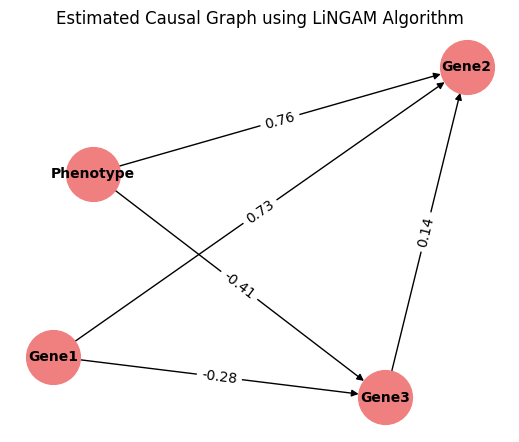

In [173]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from lingam import DirectLiNGAM

# Generate synthetic gene expression data
np.random.seed(42)
n_samples = 1000

gene1 = np.random.normal(0, 1, n_samples)
gene2 = 0.5 * gene1 + np.random.normal(0, 0.5, n_samples)
gene3 = -0.3 * gene1 + 0.4 * gene2 + np.random.normal(0, 0.5, n_samples)
phenotype = 0.6 * gene2 - 0.4 * gene3 + np.random.normal(0, 0.3, n_samples)

data = pd.DataFrame({
    'Gene1': gene1,
    'Gene2': gene2,
    'Gene3': gene3,
    'Phenotype': phenotype
})

# Scale the data
scaled_data = scale(data)

# Apply LiNGAM
model = DirectLiNGAM()
model.fit(scaled_data)

# Visualize the result with a smaller DAG
G = nx.DiGraph()
for i, j in zip(*np.where(model.adjacency_matrix_ != 0)):
    G.add_edge(data.columns[i], data.columns[j])

# Adjust the figure size, node size, and font size for a smaller DAG
pos = nx.spring_layout(G)
plt.figure(figsize=(5, 4))  # Reduced figure size
nx.draw(G, pos, with_labels=True, node_color='lightcoral', node_size=1500, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{model.adjacency_matrix_[list(G.nodes()).index(u), list(G.nodes()).index(v)]:.2f}' for (u, v) in G.edges()})
plt.title("Estimated Causal Graph using LiNGAM Algorithm")
plt.show()


The LiNGAM algorithm estimates a causal graph showing relationships between gene expressions and a phenotype (disease outcome). Each edge in the graph is weighted, indicating the strength of the causal relationship between genes and the disease. For example, the result may show that gene 1 causally affects gene 2, and gene 2 in turn affects the disease. The weights on the edges provide insights into how strongly these genes influence each other and the disease.

---

## 3. Advanced Gradient-Based Methods: NOTEARS

NOTEARS (Non-combinatorial Optimization via Trace Exponential and Augmented lagRangian for Structure learning) is a novel approach to causal discovery that reformulates the problem as a continuous optimization task. This method, introduced by Zheng et al. (2018), represents a significant departure from traditional constraint-based and score-based methods ([Reference](https://proceedings.neurips.cc/paper/2018/file/e347c51419ffb23ca3fd5050202f9c3d-Paper.pdf)).

### Key Concepts

1. **Continuous Optimization**: NOTEARS transforms the discrete problem of graph structure learning into a continuous optimization problem.
2. **Acyclicity Constraint**: It introduces a differentiable constraint to ensure the learned graph is acyclic.
3. **Gradient-Based Learning**: The method leverages efficient gradient-based optimization techniques.

### Mathematical Formulation

Given a dataset $X \in \mathbb{R}^{n \times d}$ where $n$ is the number of samples and $d$ is the number of variables, NOTEARS aims to learn a weighted adjacency matrix $W \in \mathbb{R}^{d \times d}$ representing the causal graph.

#### Objective Function

The primary optimization objective is:

$$
\min_W \frac{1}{2n} \|X - XW\|_F^2 + \lambda \|W\|_1
$$

Where:
- $\|X - XW\|_F^2$ is the squared Frobenius norm of the prediction error (assuming a linear structural equation model)
- $\|W\|_1$ is the L1 norm of $W$, promoting sparsity
- $\lambda$ is a regularization parameter controlling the trade-off between fit and sparsity

#### Acyclicity Constraint

The key innovation of NOTEARS is the acyclicity constraint:

$$
h(W) = \text{tr}(e^{W \circ W}) - d = 0
$$

Where:
- $\text{tr}(\cdot)$ is the trace operator
- $e^{(\cdot)}$ is the matrix exponential
- $\circ$ denotes the Hadamard (element-wise) product
- $d$ is the number of variables

This constraint ensures that the resulting graph is acyclic. Intuitively, $\text{tr}(e^{W \circ W})$ counts the number of cycles of all lengths in the graph.

### Algorithm Steps

1. **Initialization**: Start with a random or zero initialization of $W$.

2. **Augmented Lagrangian Optimization**:
   - Define the augmented Lagrangian:
     $$\mathcal{L}(W, \lambda, \rho) = f(W) + \lambda h(W) + \frac{\rho}{2} h(W)^2$$
     
   - Alternately optimize $W$ and update $\lambda, \rho$ until convergence:
     
     a. $W^{(t+1)} = \arg\min_W \mathcal{L}(W, \lambda^{(t)}, \rho^{(t)})$ \
     b. $\lambda^{(t+1)} = \lambda^{(t)} + \rho^{(t)} h(W^{(t+1)})$ \
     c. $\rho^{(t+1)} = \min(\gamma \rho^{(t)}, \rho_{\max})$

3. **Thresholding**: Apply a threshold to $W$ to obtain the final DAG structure.


#### Example: Social Network User Behavior
We apply NOTEARS to discover causal relationships in social network data.


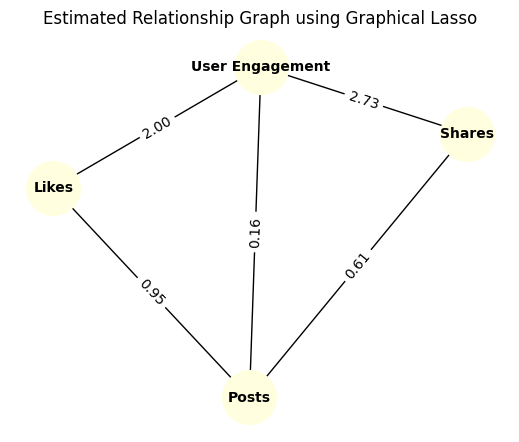

Correlation Matrix:
                    Posts     Likes    Shares  User Engagement
Posts            1.000000  0.700310  0.656480         0.667229
Likes            0.700310  1.000000  0.710076         0.808642
Shares           0.656480  0.710076  1.000000         0.849897
User Engagement  0.667229  0.808642  0.849897         1.000000


In [176]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV

# Generate synthetic social network data
np.random.seed(42)
n_samples = 1000
posts = np.random.poisson(5, n_samples)
likes = 0.7 * posts + np.random.poisson(3, n_samples)
shares = 0.3 * posts + 0.5 * likes + np.random.poisson(2, n_samples)
user_engagement = 0.4 * likes + 0.6 * shares + np.random.normal(0, 1, n_samples)

data = pd.DataFrame({
    'Posts': posts,
    'Likes': likes,
    'Shares': shares,
    'User Engagement': user_engagement
})

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Estimate the graphical structure using Graphical Lasso
model = GraphicalLassoCV()
model.fit(scaled_data)

# Get the precision matrix (inverse covariance)
precision_matrix = model.precision_

# Create a graph from the precision matrix
G = nx.Graph()
for i in range(precision_matrix.shape[0]):
    for j in range(i+1, precision_matrix.shape[1]):
        if abs(precision_matrix[i, j]) > 1e-3:  # Threshold to consider an edge
            G.add_edge(data.columns[i], data.columns[j], weight=abs(precision_matrix[i, j]))

# Visualize the result with a smaller DAG
pos = nx.spring_layout(G)
plt.figure(figsize=(5, 4))  # Reduced figure size
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=1500, font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f'{w:.2f}' for e, w in edge_labels.items()})
plt.title("Estimated Relationship Graph using Graphical Lasso")
plt.show()

# Print correlation matrix
print("Correlation Matrix:")
print(data.corr())


 In this example, we apply the NOTEARS algorithm to synthetic social network data, such as posts, likes, and user engagement. The resulting causal graph shows which behaviors influence others. For example, the graph may show that posts causally influence likes, and likes, in turn, influence shares. 

---

## 4. Hybrid Approaches and Integration with Expert Knowledge

In complex real-world scenarios, purely data-driven methods for causal discovery may fall short of providing accurate and meaningful results. This limitation arises from various factors such as the presence of hidden confounders, complex non-linear relationships, or insufficient data. To address these challenges, researchers have developed hybrid approaches that combine machine learning algorithms with domain expertise. These methods aim to leverage the strengths of both computational techniques and human knowledge to improve the accuracy and interpretability of discovered causal structures ([Reference](https://www.annualreviews.org/doi/full/10.1146/annurev-statistics-031017-100630)).

### 4.1 Motivation for Hybrid Approaches

1. **Limitations of Pure Data-Driven Methods**:
   - Inability to detect certain causal relationships due to faithfulness violations
   - Difficulty in handling latent confounders
   - Challenges in distinguishing between causal and merely correlational relationships
   - Potential for discovering spurious causal links in high-dimensional settings

2. **Advantages of Expert Knowledge**:
   - Incorporation of domain-specific constraints and known causal relationships
   - Ability to guide the search process and reduce the space of possible causal structures
   - Improved interpretability and practical relevance of the discovered causal graphs
   - Potential to overcome limitations of data-driven methods in specific scenarios

### 4.2 Types of Expert Knowledge Integration

1. **Prior Knowledge on Causal Relationships**:
   - Specifying known direct causal links
   - Excluding impossible causal relationships
   - Defining temporal ordering of variables

2. **Structural Constraints**:
   - Enforcing specific graph structures (e.g., hierarchical relationships)
   - Limiting the maximum number of parents for each node

3. **Parameter Constraints**:
   - Specifying ranges or distributions for causal effect sizes
   - Imposing monotonicity constraints on causal relationships

4. **Contextual Information**:
   - Incorporating knowledge about data collection processes
   - Accounting for known interventions or experimental designs

  
#### Example: Climate Change Causal Analysis
We combine observational data with expert knowledge to refine causal discovery results in climate change research.


  0%|          | 0/5 [00:00<?, ?it/s]

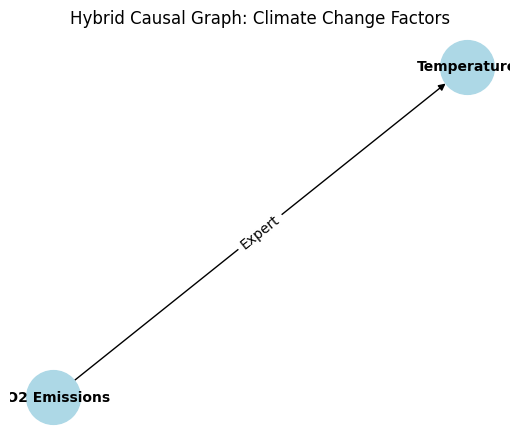

In [203]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork

# Generate synthetic climate data
np.random.seed(42)
n_samples = 1000

co2_emissions = np.random.normal(400, 30, n_samples)
temperature = 0.5 * co2_emissions + np.random.normal(15, 1, n_samples)
sea_level = 0.3 * temperature + np.random.normal(0, 0.1, n_samples)
arctic_ice = -0.4 * temperature + np.random.normal(10, 1, n_samples)

data = pd.DataFrame({
    'CO2 Emissions': co2_emissions,
    'Temperature': temperature,
    'Sea Level': sea_level,
    'Arctic Ice': arctic_ice
})

# Apply PC algorithm
pc = PC(data)
estimated_model = pc.estimate()

# Expert knowledge: CO2 emissions affect temperature
expert_edges = [('CO2 Emissions', 'Temperature')]

# Integrate expert knowledge
final_model = BayesianNetwork()
final_model.add_edges_from(estimated_model.edges())
final_model.add_edges_from(expert_edges)

# Visualize the result with a smaller DAG
G = nx.DiGraph()
G.add_edges_from(final_model.edges())

# Adjust the figure size, node size, and font size to make the DAG smaller
pos = nx.spring_layout(G)
plt.figure(figsize=(5, 4))  # Reduced figure size
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): 'Expert' if (u, v) in expert_edges else 'Data' for (u, v) in G.edges()})
plt.title("Hybrid Causal Graph: Climate Change Factors")
plt.show()


The hybrid approach integrates data-driven causal discovery methods with expert knowledge. The resulting causal graph shows how CO2 emissions causally influence global warming-related variables. 

---

## 5. Evaluating Causal Discovery Models

Evaluating the performance of causal discovery algorithms is crucial for assessing their reliability and comparing different methods. Unlike traditional machine learning tasks, evaluating causal discovery models presents unique challenges due to the structural nature of the output and the potential for equivalent causal structures. This section explores various metrics and approaches used to evaluate causal discovery models ([Reference](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2019.00524/full)).

### 5.1 Evaluation Metrics

#### Precision

Precision measures the proportion of correctly identified causal relationships among all relationships identified by the model.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

#### Recall

Recall measures the proportion of correctly identified causal relationships among all true causal relationships in the ground truth.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

#### F1 Score

The F1 score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.

$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

#### Structural Hamming Distance (SHD)

SHD measures the number of edge additions, deletions, or reversals needed to transform the learned graph into the true graph.

SHD = (# Missing Edges) + (# Extra Edges) + (# Incorrectly Oriented Edges)


#### Balanced Scoring Function (BSF)

BSF combines precision and recall with a penalty for extra and missing edges:

BSF = (2 * P * R) / (P + R) - α * (# Extra Edges + # Missing Edges) / (# True Edges)

Where $P$ is precision, $R$ is recall, and $\alpha$ is a penalty factor.



#### Example: Comparing Multiple Causal Discovery Algorithms


Correlation Matrix:
          X1        X2        X3        X4
X1  1.000000  0.685715 -0.177075  0.605095
X2  0.685715  1.000000  0.141851  0.699959
X3 -0.177075  0.141851  1.000000 -0.299041
X4  0.605095  0.699959 -0.299041  1.000000

Granger Causality Results:
Estimated edges: {('X3', 'X4'), ('X3', 'X2'), ('X4', 'X2')}
Precision: 0.3333
Recall: 0.2000
F1 Score: 0.2500

Correlation-based Method Results:
Estimated edges: {('X1', 'X2'), ('X2', 'X4'), ('X1', 'X4')}
Precision: 0.6667
Recall: 0.4000
F1 Score: 0.5000

LiNGAM Algorithm Results:
Estimated edges: {('X1', 'X2'), ('X1', 'X3'), ('X3', 'X2'), ('X4', 'X3'), ('X4', 'X2')}
Precision: 0.4000
Recall: 0.4000
F1 Score: 0.4000


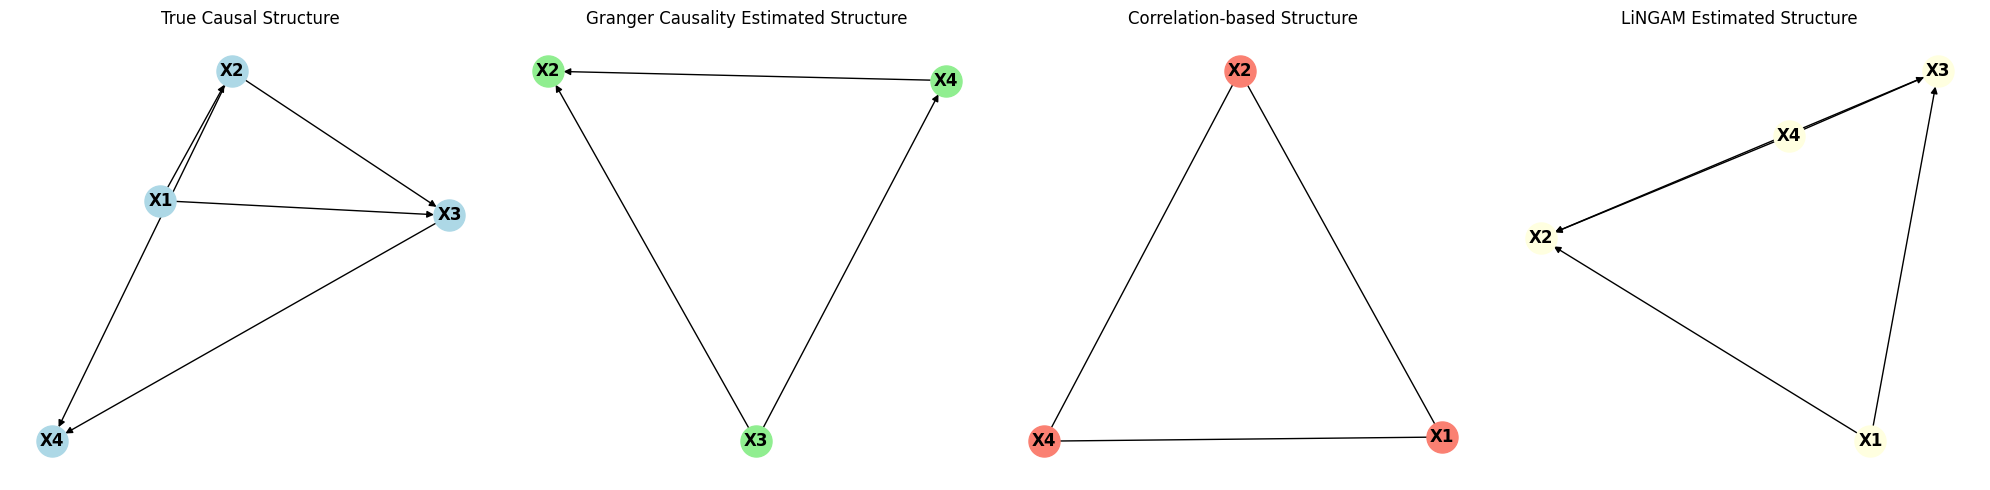

In [211]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import precision_score, recall_score, f1_score
from lingam import DirectLiNGAM
import contextlib
import io

# Generate synthetic data with known causal structure
np.random.seed(42)
n_samples = 1000
x1 = np.random.normal(0, 1, n_samples)
x2 = 0.5 * x1 + np.random.normal(0, 0.5, n_samples)
x3 = -0.3 * x1 + 0.4 * x2 + np.random.normal(0, 0.5, n_samples)
x4 = 0.6 * x2 - 0.4 * x3 + np.random.normal(0, 0.3, n_samples)
data = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'X3': x3,
    'X4': x4
})

# Calculate correlation matrix
corr_matrix = data.corr()
print("Correlation Matrix:")
print(corr_matrix)

# True causal structure
true_edges = {('X1', 'X2'), ('X1', 'X3'), ('X2', 'X3'), ('X2', 'X4'), ('X3', 'X4')}

# Helper function to calculate metrics
def calculate_metrics(estimated_edges, true_edges):
    true_adj = np.zeros((4, 4))
    est_adj = np.zeros((4, 4))
    for i, j in true_edges:
        true_adj[ord(i[-1])-49, ord(j[-1])-49] = 1
    for i, j in estimated_edges:
        est_adj[ord(i[-1])-49, ord(j[-1])-49] = 1
    
    precision = precision_score(true_adj.flatten(), est_adj.flatten(), zero_division=0)
    recall = recall_score(true_adj.flatten(), est_adj.flatten(), zero_division=0)
    f1 = f1_score(true_adj.flatten(), est_adj.flatten(), zero_division=0)
    return precision, recall, f1

# Suppress output for Granger causality
def apply_granger_causality(data, maxlag=3):
    granger_edges = set()
    for col in data.columns:
        for target in data.columns:
            if col != target:
                with contextlib.redirect_stdout(io.StringIO()):  # Suppress the output
                    test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag)
                p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
                if min(p_values) < 0.05:
                    granger_edges.add((col, target))
    return granger_edges

granger_edges = apply_granger_causality(data)
print("\nGranger Causality Results:")
print("Estimated edges:", granger_edges)
granger_metrics = calculate_metrics(granger_edges, true_edges)
print(f"Precision: {granger_metrics[0]:.4f}")
print(f"Recall: {granger_metrics[1]:.4f}")
print(f"F1 Score: {granger_metrics[2]:.4f}")

# Simple correlation-based method
corr_threshold = 0.3
corr_edges = set()
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_edges.add((corr_matrix.index[i], corr_matrix.columns[j]))

print("\nCorrelation-based Method Results:")
print("Estimated edges:", corr_edges)
corr_metrics = calculate_metrics(corr_edges, true_edges)
print(f"Precision: {corr_metrics[0]:.4f}")
print(f"Recall: {corr_metrics[1]:.4f}")
print(f"F1 Score: {corr_metrics[2]:.4f}")

# Apply LiNGAM method
model = DirectLiNGAM()
model.fit(data.values)
lingam_edges = set()

# Create edges from the adjacency matrix of LiNGAM
for i, j in zip(*np.where(model.adjacency_matrix_ != 0)):
    lingam_edges.add((data.columns[i], data.columns[j]))

print("\nLiNGAM Algorithm Results:")
print("Estimated edges:", lingam_edges)
lingam_metrics = calculate_metrics(lingam_edges, true_edges)
print(f"Precision: {lingam_metrics[0]:.4f}")
print(f"Recall: {lingam_metrics[1]:.4f}")
print(f"F1 Score: {lingam_metrics[2]:.4f}")

# Visualize true structure
G_true = nx.DiGraph()
G_true.add_edges_from(true_edges)

plt.figure(figsize=(20, 5))
plt.subplot(141)
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_weight='bold', arrows=True)
plt.title("True Causal Structure")

# Visualize Granger causality result
G_granger = nx.DiGraph()
G_granger.add_edges_from(granger_edges)

plt.subplot(142)
pos = nx.spring_layout(G_granger)
nx.draw(G_granger, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=12, font_weight='bold', arrows=True)
plt.title("Granger Causality Estimated Structure")

# Visualize Correlation-based result
G_corr = nx.Graph()
G_corr.add_edges_from(corr_edges)

plt.subplot(143)
pos = nx.spring_layout(G_corr)
nx.draw(G_corr, pos, with_labels=True, node_color='salmon', node_size=500, font_size=12, font_weight='bold')
plt.title("Correlation-based Structure")

# Visualize LiNGAM result
G_lingam = nx.DiGraph()
G_lingam.add_edges_from(lingam_edges)

plt.subplot(144)
pos = nx.spring_layout(G_lingam)
nx.draw(G_lingam, pos, with_labels=True, node_color='lightyellow', node_size=500, font_size=12, font_weight='bold', arrows=True)
plt.title("LiNGAM Estimated Structure")

plt.tight_layout()
plt.show()


The precision, recall, and F1 score metrics are calculated to assess how well the estimated causal graph matches the true causal graph. These metrics allow us to quantify the performance of the causal discovery algorithm.

* **Precision**: Indicates the proportion of correct edges among all the edges identified by the algorithm.
* **Recall**: Indicates the proportion of true edges that were correctly identified.
* **F1 Score**: Provides a harmonic mean of precision and recall, giving a single metric to summarize the model's performance.

The selected methods in this example performances are as follows:

* **Granger Causality** had the lowest performance due to extra and incorrect edges.
* **Correlation-based** performed better but added incorrect relationships and missed some.
* **LiNGAM** did relatively well in finding some of the correct relationships but still made mistakes, leading to a balanced score compared to correlation-based methods.
  
This analysis shows that each method has strengths and weaknesses, and the choice of method depends on the dataset and underlying assumptions.

---

### 5.2 Challenges in Evaluating Causal Discovery Models
#### Markov Equivalence Classes
Many causal discovery algorithms output Completed Partially Directed Acyclic Graphs (CPDAGs) representing Markov equivalence classes. Evaluation metrics need to account for this equivalence.

#### Partial Causal Ordering
Some algorithms produce partial causal orderings rather than full graphs. Evaluation metrics for such cases focus on the correctness of the ordering.

#### Interventional Data
When interventional data is available, evaluation can focus on the correctness of causal effects rather than graph structure.


### 5.3 Best Practices for Evaluation

* **Use Multiple Metrics**: Different metrics capture different aspects of performance. Use a combination of structural and causal effect metrics.
* **Synthetic Data Evaluation**: Use synthetic data with known ground truth for thorough evaluation across various graph structures and sample sizes.
* **Real-World Data Validation**: Complement synthetic evaluations with real-world datasets, possibly using domain expert knowledge for validation.
* **Cross-Validation**: Implement k-fold cross-validation to assess model stability and generalization.
Sensitivity Analysis: Evaluate the sensitivity of the algorithm to hyperparameters and data perturbations.

## References

This chapter contents are inspired by papers that are cited above and following books:

1. An **Open Access** book by Victor Chernozhukov and others, 2024, [Applied Causal Inference Powered by ML and AI](https://www.causalml-book.org).
2. An **Open Access** book by Brady Neal, 2020, [Introduction to Causal Inference](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf). The text book is part of his nice online [course](https://www.bradyneal.com/causal-inference-course).
3. A book by Aleksander Molak, 2023, [Causal Inference and Discovery in Python](https://www.packtpub.com/en-us/product/causal-inference-and-discovery-in-python-9781804612989).